In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import gc

import lightgbm as lgb
from sklearn import preprocessing

import optuna
from optuna.visualization import (
    plot_contour
    , plot_edf
    , plot_intermediate_values
    , plot_optimization_history
    , plot_parallel_coordinate
    , plot_param_importances
    , plot_slice
)

pd.set_option('display.max_columns', None)


import plotly.express as px
import plotly.io as pio
pio.renderers.default = "png"

/home/mavillan/mambaforge/envs/kg/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


***
## loading data

In [2]:
input_path = "../data/raw"

train = pd.read_csv(f"{input_path}/train.csv")
test  = pd.read_csv(f"{input_path}/test.csv")
greeks = pd.read_csv(f"{input_path}/greeks.csv")

train.columns = [col.strip() for col in train.columns]
test.columns = [col.strip() for col in test.columns]

# available features
input_cols = train.columns[1:-1]
categ_cols = ["EJ"]

# we extend train with dummies from greeks
dummies = pd.get_dummies(greeks[["Alpha","Beta","Gamma","Delta"]])
train[dummies.columns] = dummies

# encode of categorical features
encoder = preprocessing.LabelEncoder().fit(train["EJ"])
train["EJ"] = encoder.transform(train["EJ"]).astype(int)
test["EJ"] = encoder.transform(test["EJ"]).astype(int)

display(train)

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,BN,BP,BQ,BR,BZ,CB,CC,CD,CF,CH,CL,CR,CS,CU,CW,DA,DE,DF,DH,DI,DL,DN,DU,DV,DY,EB,EE,EG,EH,EJ,EL,EP,EU,FC,FD,FE,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class,Alpha_A,Alpha_B,Alpha_D,Alpha_G,Beta_A,Beta_B,Beta_C,Gamma_A,Gamma_B,Gamma_E,Gamma_F,Gamma_G,Gamma_H,Gamma_M,Gamma_N,Delta_A,Delta_B,Delta_C,Delta_D
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,22.5984,175.638726,152.707705,823.928241,257.432377,47.223358,0.563481,23.387600,4.851915,0.023482,1.050225,0.069225,13.784111,1.302012,36.205956,69.08340,295.570575,0.238680,0.284232,89.245560,84.31664,29.657104,5.310690,1.74307,23.187704,7.294176,1.987283,1433.166750,0.949104,1,30.879420,78.526968,3.828384,13.394640,10.265073,9028.291921,3.583450,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,19.4205,155.868030,14.754720,51.216883,257.432377,30.284345,0.484710,50.628208,6.085041,0.031442,1.113875,1.117800,28.310953,1.357182,37.476568,70.79836,178.553100,0.238680,0.363489,110.581815,75.74548,37.532000,0.005518,1.74307,17.222328,4.926396,0.858603,1111.287150,0.003042,0,109.125159,95.415086,52.260480,17.175984,0.296850,6785.003474,10.358927,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.78024,26.4825,128.988531,219.320160,482.141594,257.432377,32.563713,0.495852,85.955376,5.376488,0.036218,1.050225,0.700350,39.364743,1.009611,21.459644,70.81970,321.426625,0.238680,0.210441,120.056438,65.46984,28.053464,1.289739,1.74307,36.861352,7.813674,8.146651,1494.076488,0.377208,1,109.125159,78.526968,5.390628,224.207424,8.745201,8338.906181,11.626917,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.67738,23.6577,237.282264,11.050410,661.518640,257.432377,15.201914,0.717882,88.159360,2.347652,0.029054,1.400300,0.636075,41.116960,0.722727,21.530392,47.27586,196.607985,0.238680,0.292431,139.824570,71.57120,24.354856,2.655345,1.74307,52.003884,7.386060,3.813326,15691.552180,0.614484,1,31.674357,78.526968,31.323372,59.301984,7.884336,10965.766040,14.852022,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,24.0108,324.546318,149.717165,6074.859475,257.432377,82.213495,0.536467,72.644264,30.537722,0.025472,1.050225,0.693150,31.724726,0.827550,34.415360,74.06532,200.178160,0.238680,0.207708,97.920120,52.83888,26.019912,1.144902,1.74307,9.064856,7.350720,3.490846,1403.656300,0.164268,1,109.125159,91.994825,51.141336,29.102640,4.274640,16198.049590,13.666727,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,fd3dafe738fd,0.149555,3130.05946,123.763599,9.513984,13.020852,3.499305,0.077343,8.545512,2.804172,4157.68439,21.1860,167.877117,27.287375,365.516874,257.432377,41.368691,0.691257,55.163024,4.780452,0.013930,1.177525,0.698250,40.159779,1.070298,7.030640,21.75904,355.930925,0.238680,0.445479,176.977590,90.91832,27.957928,0.005518,2.41906,32.508604,8.015112,1.354416,495.086300,0.003042,0,51.

In [3]:
repeated_cv_split = joblib.load("../data/iarc-data-split/repeated_5fold_cv_split_4tuning.pkl")
print(len(repeated_cv_split))

# number of repetitions to use
REPETITIONS = 10

10


***
## training

In [4]:
def balanced_logloss_(y_pred, y_true):
    n0 = np.sum(1-y_true)
    n1 = np.sum(y_true)
    p1 = np.clip(y_pred, 1e-15, 1-1e-15)
    p0 = 1-p1
    log_loss0 = - np.sum((1-y_true) * np.log(p0)) / n0
    log_loss1 = - np.sum(y_true * np.log(p1)) / n1
    return (log_loss0 + log_loss1)/2

def balanced_logloss(y_pred: np.ndarray, data: lgb.Dataset):
    y_true = data.get_label()
    return 'balanced_logloss', balanced_logloss_(y_pred, y_true), False 

In [5]:
pct = train.Class.value_counts(normalize=True)
scale_pos_weight = pct[0]/pct[1]
print("scale_pos_weight:", scale_pos_weight)

cnt = train.Class.value_counts(normalize=False)
neg_bagging_fraction = cnt[1]/cnt[0]
print("neg_bagging_fraction:", neg_bagging_fraction)

scale_pos_weight: 4.712962962962963
neg_bagging_fraction: 0.21218074656188604


In [6]:
#balance_method = "weight"
balance_method = "bagging"

DEFAULT_PARAMS = {
    'objective': 'binary',
    'metric': 'None',
    'learning_rate': 0.005,
    'seed': 2112,
    'first_metric_only': False,
    'feature_pre_filter': False,
    'verbosity':-1,
}

if balance_method == "weight":
    DEFAULT_PARAMS["scale_pos_weight"] = scale_pos_weight
elif balance_method == "bagging":
    DEFAULT_PARAMS["bagging_freq"] = 1
    DEFAULT_PARAMS["pos_bagging_fraction"] = 1
    DEFAULT_PARAMS["neg_bagging_fraction"] = neg_bagging_fraction
else:
    print("Unknown balance_method")
    
display(DEFAULT_PARAMS)

{'objective': 'binary',
 'metric': 'None',
 'learning_rate': 0.005,
 'seed': 2112,
 'first_metric_only': False,
 'feature_pre_filter': False,
 'verbosity': -1,
 'bagging_freq': 1,
 'pos_bagging_fraction': 1,
 'neg_bagging_fraction': 0.21218074656188604}

In [7]:
def train_validate(
        dataframe,
        input_cols, 
        model_params,
        repeated_cv_split,
        n_repetitions=REPETITIONS,
        verbose=False,
    ):

    metrics = list()
    model_params = dict(model_params)
    num_iterations = (
        2000 if "num_iterations" not in model_params.keys() 
        else model_params.pop("num_iterations")
    )

    for repeat in range(n_repetitions):
        if verbose:
            print(f"REPEAT NUMBER: {repeat+1}/{n_repetitions}")
        cv_split = repeated_cv_split[f"repeat_{repeat}"]
        n_folds = len(cv_split)
        
        for split in cv_split:
            fold = split["fold"]
            train_idx = split["train_idx"]
            valid_idx = split["valid_idx"]
            if verbose:
                print(f"training model for fold: {fold+1}/{n_folds}")
        
            train_df = dataframe.loc[train_idx,:].reset_index(drop=True)
            valid_df = dataframe.loc[valid_idx,:].reset_index(drop=True)

            train_dset = lgb.Dataset(
                data=train_df.loc[:,input_cols],
                label=train_df.loc[:,"Class"].values,
                free_raw_data=False
            )
            model = lgb.train(
                params=model_params,
                train_set=train_dset,
                num_boost_round=num_iterations,
            )
            
            if verbose:
                lgb.plot_importance(model, importance_type="gain", figsize=(8,15))
                plt.show()
                lgb.plot_importance(model, importance_type="split", figsize=(8,15))
                plt.show()

            y_pred = model.predict(valid_df.loc[:,input_cols])
            metrics.append( balanced_logloss_(y_pred, valid_df.loc[:,"Class"].values) )
    
    return np.mean(metrics), np.std(metrics)


def objective(trial):
    sampled_params = dict(
        # general booster config
        max_bin = 2**trial.suggest_int("max_bin_exp", 5, 8) - 1,
        num_leaves = 2**trial.suggest_int("num_leaves_exp", 2, 5) - 1,
        num_iterations = trial.suggest_int("num_iterations", 1000, 5000),
        # regularization
        feature_fraction = trial.suggest_float("feature_fraction", 0.2, 0.8, step=0.05),
        min_data_in_leaf = trial.suggest_int("min_data_in_leaf", 5, 50),
        
        lambda_l1 = trial.suggest_float("lambda_l1", 1e-5, 1e1, log=True),
        lambda_l2 = trial.suggest_float("lambda_l2", 1e-5, 1e1, log=True),
        path_smooth = trial.suggest_float("path_smooth", 1e-5, 1e1, log=True),
        min_gain_to_split = trial.suggest_float("min_gain_to_split", 1e-5, 1e1, log=True),
        
        # dart
        #drop_rate = trial.suggest_discrete_uniform("drop_rate", 0.05, 0.2, 0.01),
        #max_drop = trial.suggest_int("max_drop", 10, 100, 10),
        #skip_drop = trial.suggest_discrete_uniform("skip_drop", 0.2, 0.8, 0.05),
    )
    model_params = {**DEFAULT_PARAMS, **sampled_params}
    
    metric_mean, metric_std = train_validate(
        dataframe = train,
        input_cols = input_cols,
        model_params = model_params,
        repeated_cv_split = repeated_cv_split,
        n_repetitions = REPETITIONS,
        verbose = False,
    )
    
    return metric_mean

In [8]:
%%time

train_validate(
    dataframe = train,
    input_cols = input_cols,
    model_params = DEFAULT_PARAMS,
    repeated_cv_split = repeated_cv_split,
    n_repetitions = REPETITIONS,
    verbose = False
    
)

CPU times: user 5min 14s, sys: 3.71 s, total: 5min 18s
Wall time: 39.9 s


(0.2414773648412618, 0.06894740241902327)

In [9]:
do_optimize = True

study = optuna.create_study(
    study_name="iarc-lgbm-gbrt-bagging-balanced",
    direction='minimize',
    storage='sqlite:///iarc-lgbm-gbrt-bagging-balanced.db',
    load_if_exists=True,
)

if do_optimize:
    study.optimize(
        objective, 
        n_trials=5, 
        timeout=43200, # 12 hours
        n_jobs=1, 
        gc_after_trial=True,
    ) 

[I 2023-06-16 00:24:53,534] Using an existing study with name 'iarc-lgbm-gbrt-bagging-balanced' instead of creating a new one.
[I 2023-06-16 00:25:11,636] Trial 10 finished with value: 0.28310646019721514 and parameters: {'feature_fraction': 0.2, 'lambda_l1': 1.4146065938183185e-05, 'lambda_l2': 1.6870646345469593, 'max_bin_exp': 6, 'min_data_in_leaf': 33, 'min_gain_to_split': 2.932210514221272e-05, 'num_iterations': 1829, 'num_leaves_exp': 4, 'path_smooth': 1.0817873734079257e-05}. Best is trial 3 with value: 0.2457916898526549.
[I 2023-06-16 00:25:39,633] Trial 11 finished with value: 0.2539599948170187 and parameters: {'feature_fraction': 0.65, 'lambda_l1': 0.00012859608198897312, 'lambda_l2': 0.07391359723369377, 'max_bin_exp': 5, 'min_data_in_leaf': 16, 'min_gain_to_split': 0.1789697380294637, 'num_iterations': 2696, 'num_leaves_exp': 2, 'path_smooth': 0.27953140517128866}. Best is trial 3 with value: 0.2457916898526549.
[I 2023-06-16 00:26:11,879] Trial 12 finished with value: 0.

In [10]:
study.trials_dataframe().sort_values("value", ascending=True).head(20)

,number,value,datetime_start,datetime_complete,duration,params_feature_fraction,params_lambda_l1,params_lambda_l2,params_max_bin_exp,params_min_data_in_leaf,params_min_gain_to_split,params_num_iterations,params_num_leaves_exp,params_path_smooth,state
3,3,0.245792,2023-06-16 00:05:11.554788,2023-06-16 00:05:54.907569,0 days 00:00:43.352781,0.65,0.000020,0.522639,5,27,0.120639,3354,3,0.000057,COMPLETE
9,9,0.253870,2023-06-16 00:15:00.851316,2023-06-16 00:15:35.986415,0 days 00:00:35.135099,0.70,0.000773,0.013451,5,13,0.005157,3393,2,7.537333,COMPLETE
11,11,0.253960,2023-06-16 00:25:11.773566,2023-06-16 00:25:39.615584,0 days 00:00:27.842018,0.65,0.000129,0.073914,5,16,0.178970,2696,2,0.279531,COMPLETE
5,5,0.254299,2023-06-16 00:12:03.497656,2023-06-16 00:12:52.004227,0 days 00:00:48.506571,0.40,1.014688,0.000032,5,24,0.024079,4213,5,1.114675,COMPLETE
13,13,0.255417,2023-06-16 00:26:12.003283,2023-06-16 00:27:00.069380,0 days 00:00:48.066097,0.65,0.004331,0.086174,5,16,0.233541,3179,4,6.929622,COMPLETE
2,2,0.256222,2023-06-16 00:04:32.835155,2023-06-16 00:05:11.379533,0 days 00:00:38.544378,0.40,0.000016,0.000379,7,46,0.040613,3802,2,0.008311,COMPLETE
7,7,0.262002,2023-06-16 00:13:41.397868,2023-06-16 00:14:31.970519,0 days 00:00:50.572651,0.50,0.001987,5.175718,7,44,0.050791,4813,3,4.051171,COMPLETE
6,6,0.264016,2023-06-16 00:12:52.150669,2023-06-16 00:13:41.248196,0 days 00:00:49.097527,0.75,0.039654,0.004648,6,32,0.001633,3693,5,0.002578,COMPLETE
14,14,0.265419,2023-06-16 00:27:00.227443,2023-06-16 00:27:19.888708,0 days 00:00:19.661265,0.70,0.000083,0.408137,5,21,0.000356,1946,2,0.036873,COMPLETE
4,4,0.272941,2023-06-16 00:05:55.076157,2023-06-16 00:07:10.873286,0 days 00:01:15.797129,0.50,0.546436,0.000368,5,6,0.014161,4773,5,0.002565,COMPLETE


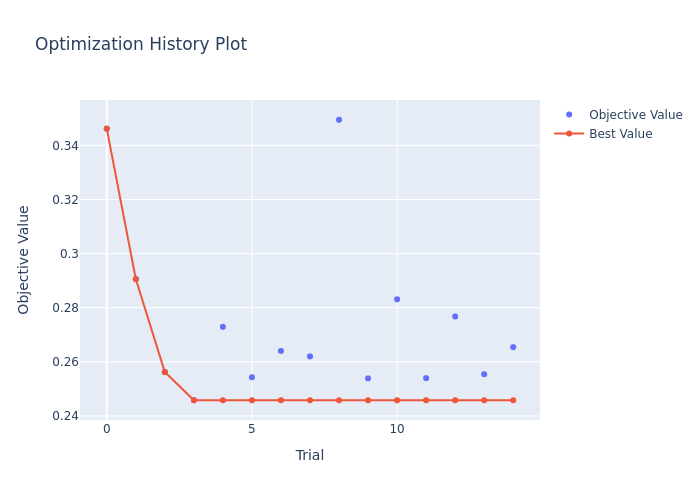

In [11]:
plot_optimization_history(study)

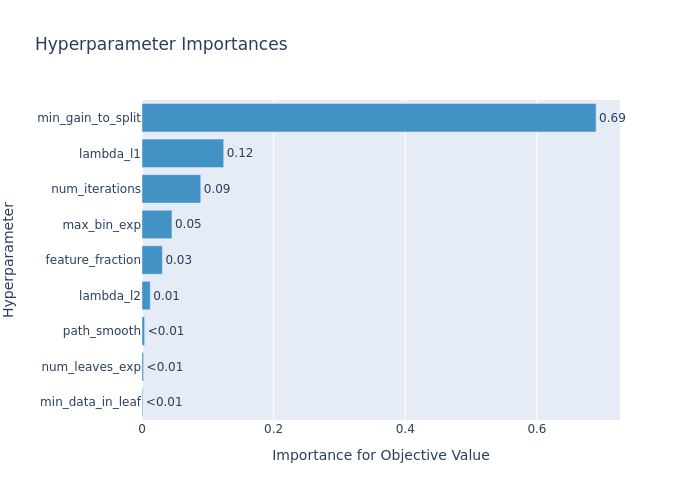

In [12]:
plot_param_importances(study)

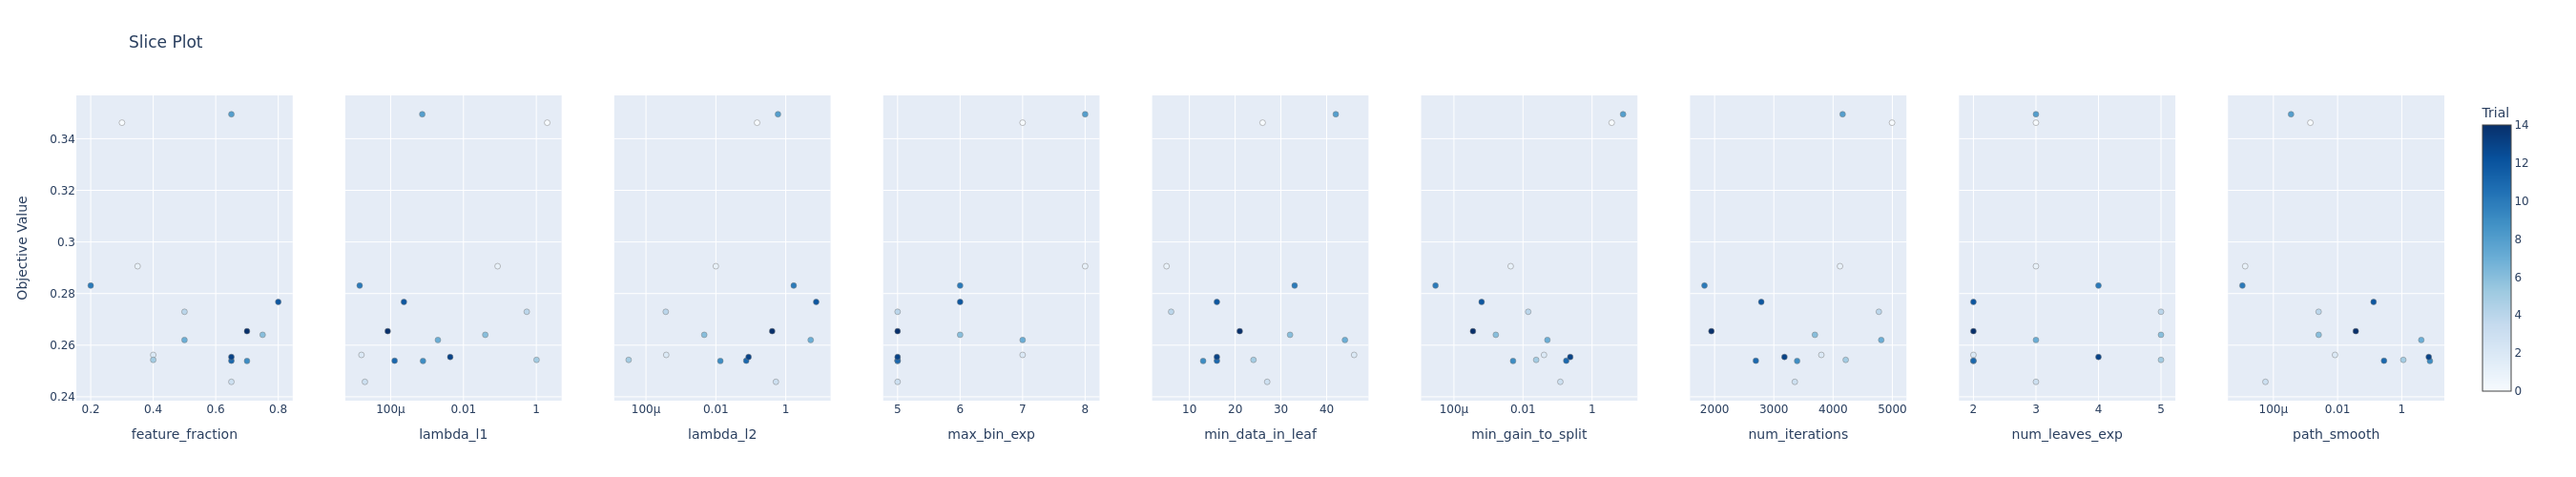

In [13]:
plot_slice(study)

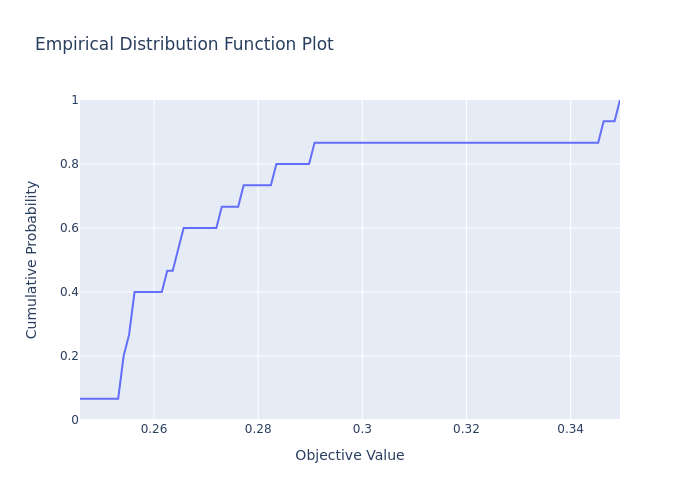

In [14]:
plot_edf(study)

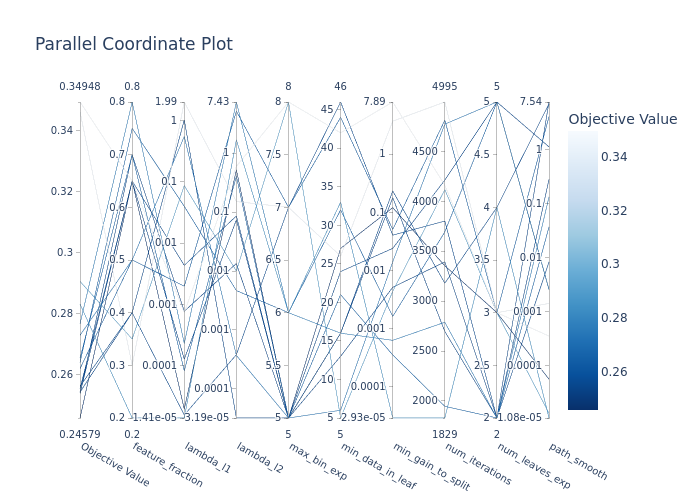

In [15]:
plot_parallel_coordinate(study)

In [16]:
best_params = dict(study.best_params)
best_params["max_bin"] = 2**best_params.pop("max_bin_exp")-1
best_params["num_leaves"] = 2**best_params.pop("num_leaves_exp")-1
best_params = {**DEFAULT_PARAMS, **best_params}
best_params

{'objective': 'binary',
 'metric': 'None',
 'learning_rate': 0.005,
 'seed': 2112,
 'first_metric_only': False,
 'feature_pre_filter': False,
 'verbosity': -1,
 'bagging_freq': 1,
 'pos_bagging_fraction': 1,
 'neg_bagging_fraction': 0.21218074656188604,
 'feature_fraction': 0.65,
 'lambda_l1': 1.9656729890508476e-05,
 'lambda_l2': 0.5226387785340926,
 'min_data_in_leaf': 27,
 'min_gain_to_split': 0.12063857981764985,
 'num_iterations': 3354,
 'path_smooth': 5.651885210641881e-05,
 'max_bin': 31,
 'num_leaves': 7}

***